In [ ]:
# Sonum
# 1001859905

import pandas as pd
import numpy as np
import math
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


## Reading the CSV files

In [ ]:
df_test=pd.read_csv(r'btest.csv')
df_train=pd.read_csv(r'btrain.csv')
df_validate=pd.read_csv(r'bvalidate.csv')


## Cleaning the Data

In [ ]:
# replacing the '?' with np.nan
df_train=df_train.replace('?',np.nan)
df_test=df_test.replace('?',np.nan)
df_validate=df_validate.replace('?',np.nan)

# Cleaning the column names
df_train.columns = df_train.columns.str.strip().str.lower()
output_df = df_test.iloc[:,:-1]  # Save the output column for later use
df_test.columns = df_test.columns.str.strip().str.lower()
df_validate.columns = df_validate.columns.str.strip().str.lower()


for i in df_train.columns:
    if df_train[i].dtype == np.number:
        mean = df_train[i].dropna().mean()
        df_train[i]=df_train[i].fillna(mean)
        df_test[i]=df_test[i].fillna(mean)
        df_validate[i]=df_validate[i].fillna(mean)
    else:
        mode = df_train[i].dropna().mode().iloc[0]
        df_train[i]=df_train[i].fillna(mode)
        df_test[i]=df_test[i].fillna(mode)
        df_validate[i]=df_validate[i].fillna(mode)

## Converting to appropriate Type

In [ ]:
lis=df_train.columns
print(lis[0:-1])
for i in lis[0:-1]:
    df_train[i]=df_train[i].astype('float64')
    df_test[i]=df_test[i].astype('float64')
    df_validate[i]=df_validate[i].astype('float64')
data_num = ['winpercent','oppwinpercent','temperature','numinjured','oppnuminjured','dayssincegame','oppdayssincegame','rundifferential','opprundifferential']

Index(['winpercent', 'oppwinpercent', 'weather', 'temperature', 'numinjured',
       'oppnuminjured', 'startingpitcher', 'oppstartingpitcher',
       'dayssincegame', 'oppdayssincegame', 'homeaway', 'rundifferential',
       'opprundifferential'],
      dtype='object')


## Preprocessing the Dataframe

In [ ]:
for i in data_num:
    col_min = df_train[i].min()
    col_max = df_train[i].max()
    df_train[i] = (df_train[i] - col_min) / (col_max - col_min)
    df_test[i] = (df_test[i] - col_min) / (col_max - col_min)
    df_validate[i] = (df_validate[i] - col_min) / (col_max - col_min)

lisss = []
for i in data_num:
    for j in range(0, 10):
        range_col=i+'_'+str(j)+'_'+str(j+1)
        lisss.append(range_col)
        df_train[range_col] = ((df_train[i] >= j/10) & (df_train[i] < (j+1)/10)).astype(int)
        df_test[range_col] = ((df_test[i] >= j/10) & (df_test[i] < (j+1)/10)).astype(int)
        df_validate[range_col] = ((df_validate[i] >= j/10) & (df_validate[i] < (j+1)/10)).astype(int)



In [ ]:
# Drop the original numeric columns from the dataframes
df_train = df_train.drop(columns=data_num)
df_test = df_test.drop(columns=data_num)
df_validate = df_validate.drop(columns=data_num)

In [ ]:
# Split the target variable from the dataframes and store them in separate variables
target_column = "winner"
df_train_label = df_train[target_column]
df_test_label = df_test[target_column]
df_validate_label = df_validate[target_column]

In [ ]:
# Drop the target variable column from the dataframes
df_train = df_train.drop(target_column, axis=1)
df_test = df_test.drop(target_column, axis=1)
df_validate = df_validate.drop(target_column, axis=1)

In [ ]:
# Create dummy variables for categorical variables in the dataframes using one-hot encoding
categorical_columns = ["weather", "startingpitcher", "oppstartingpitcher", "homeaway"]
df_train = pd.get_dummies(df_train, columns=categorical_columns)
df_test = pd.get_dummies(df_test, columns=categorical_columns)
df_validate = pd.get_dummies(df_validate, columns=categorical_columns)

In [ ]:
# Add the target variable columns back to the dataframes
df_train[target_column] = df_train_label
df_test[target_column] = df_test_label
df_validate[target_column] = df_validate_label

In [ ]:
# Convert all columns in the dataframes to numeric type, ignoring any non-numeric values by setting errors='coerce'
df_train = df_train.apply(pd.to_numeric, errors='coerce')
df_test = df_test.apply(pd.to_numeric, errors='coerce')
df_validate = df_validate.apply(pd.to_numeric, errors='coerce')

## Code for Decision Tree Implementation using Information Gain

In [ ]:
# define a Node class to represent each node of the decision tree
class Node:
    def __init__(self, is_leaf=False, label=None, attribute=None, children=None):
        self.is_leaf = is_leaf
        self.label = label
        self.attribute = attribute
        self.children = children if children is not None else {}

In [ ]:
# Define the ID3 algorithm (information Gain)
def id3(data, target_attribute):
    # if all examples have the same label, return a leaf node with that label
    if len(set(data[target_attribute])) == 1:
        return Node(is_leaf=True, label=data[target_attribute].iloc[0])
    # if there are no attributes left to split on, return a leaf node with the majority label
    if len(data.columns) == 1:
        return Node(is_leaf=True, label=data[target_attribute].value_counts().idxmax())
    # otherwise, choose the best attribute to split on and create a new node
    else:
        best_attribute = choose_attribute(data, target_attribute)
        node = Node(attribute=best_attribute)
        # split the data based on the best attribute and create child nodes
        for value in data[best_attribute].unique():
            subset = data[data[best_attribute] == value].drop(best_attribute, axis=1)
            child_node = id3(subset, target_attribute)
            node.children[value] = child_node
        return node

# define a function to choose the best attribute to split on
def choose_attribute(data, target_attribute):
    best_attribute = None
    best_gain = -math.inf
    for attribute in data.columns:
        if attribute == target_attribute:
            continue
        gain = information_gain(data, attribute, target_attribute)
        if gain > best_gain:
            best_gain = gain
            best_attribute = attribute
    return best_attribute

# define a function to calculate the information gain of an attribute
def information_gain(data, attribute, target_attribute):
    entropy_before = entropy(data[target_attribute])
    values = data[attribute].unique()
    entropy_after = 0
    for value in values:
        subset = data[data[attribute] == value]
        weight = len(subset) / len(data)
        entropy_after += weight * entropy(subset[target_attribute])
    return entropy_before - entropy_after

# define a function to calculate the entropy of a set of labels
def entropy(labels):
    total = len(labels)
    counts = labels.value_counts()
    probabilities = counts / total
    entropy = -sum(probabilities * np.log2(probabilities))
    return entropy

## Fitting the Data on Decision Tree and predicting on the Datasets

In [ ]:
# build the decision tree
root = id3(df_train, "winner")
df_test=df_test.drop('winner',axis=1)

# define a function to make predictions using the decision tree
def predict(node, example):
    if node.is_leaf:
        return node.label
    else:
        value = example[node.attribute]
        if value not in node.children:
            return None
        else:
            child_node = node.children[value]
            return predict(child_node, example)

# make predictions on the test data
predictions_test = []
for i, example in df_test.iterrows():
    prediction = predict(root, example)
    predictions_test.append(prediction)


# make predictions on the validation data
actual = df_validate["winner"]
df_validate=df_validate.drop('winner', axis=1)
predictions_validate = []
for i, example in df_validate.iterrows():
    prediction = predict(root, example)
    predictions_validate.append(prediction)

correct = 0
for i in range(len(actual)):
    if actual.iloc[i] == predictions_validate[i]:
        correct += 1

accuracy = correct / len(actual)
print("Accuracy of validation data is :", accuracy)


Accuracy of validation data is : 0.843


## Print predicted values on test Dataset and store in CSV file

In [ ]:
print("Predicted values on Test Dataset is: ",predictions_test)
df_test['winner']=predictions_test
df_test['winner'].to_csv("new_test.csv",index=False)

Predicted values on Test Dataset is:  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0

## Visualise the Decision Tree

[Text(0.5, 0.75, 'X[105] <= 0.5\nentropy = 0.945\nsamples = 50000\nvalue = [18145, 31855]'),
 Text(0.25, 0.25, 'entropy = 0.0\nsamples = 18145\nvalue = [18145, 0]'),
 Text(0.75, 0.25, 'entropy = 0.0\nsamples = 31855\nvalue = [0, 31855]')]

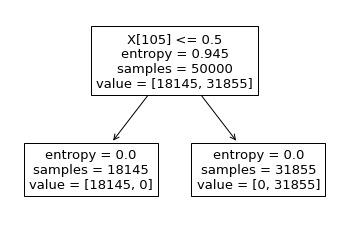

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
def visualize_tree(tree=None, depth=0, feature_names=None):
    """
    Visualizes the decision tree using Matplotlib.

    Args:
    - tree: dictionary representing the decision tree
    - depth: int specifying the current depth of the tree (default=0)
    - feature_names: list of strings representing the names of the features (default=None)
    """
    # Base case: if the tree is a leaf node
    if isinstance(tree, str):
        plt.text(0.5, depth, tree, ha='center', va='center')
        return
    

    # Plot the feature and value of the current node
    plt.text(0.5, depth, f'{feature_names[tree["feature"]]} <= {tree["value"]}\ngain={tree["gain"]:.2f}', ha='center', va='center', bbox=dict(facecolor='lightgray', edgecolor='none', boxstyle='round'))

    # Visualize the left subtree
    plt.plot([0.25, 0.5], [depth, depth-1], linewidth=1.0, color='black')
    visualize_tree(tree['left_subtree'], depth-1, feature_names)

    # Visualize the right subtree
    plt.plot([0.5, 0.75], [depth, depth-1], linewidth=1.0, color='black')
    visualize_tree(tree['right_subtree'], depth-1, feature_names)



clf = tree.DecisionTreeClassifier(max_depth=5,criterion='entropy')
clf = clf.fit(df_train, df_train['winner'])
tree.plot_tree(clf)

# # DOT data
# dot_data = tree.export_graphviz(clf, out_file=None, 
#                                 feature_names=lis[0:-1],  
#                                 class_names=df_train['winner'],
#                                 filled=True)

# # Draw graph
# graph = graphviz.Source(dot_data, format="png") 
# graph

# Example usage
# root = build_tree(data, 3)
# visualize_tree()
# plt.axis('off')
# plt.show()
